## Importing Libraries

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

## Loading Dataset

In [19]:
df = pd.read_csv("customer_transactions_mock_data.csv")
df.head(5)

,TransactionID,CustomerID,TransactionDate,ProductID,Quantity,UnitPrice,TotalPrice
0,TRX50000_0,CUST1302,2022-01-12,Prod_107,3,53.74,161.22
1,TRX50000_1,CUST1302,2022-01-12,Prod_104,2,43.15,86.30
2,TRX50000_2,CUST1302,2022-01-12,Prod_107,1,59.80,59.80
3,TRX50001_0,CUST1267,2023-10-17,Prod_108,1,214.31,214.31
4,TRX50001_1,CUST1267,2023-10-17,Prod_109,3,312.02,936.06


## Data Preprocessing

In [20]:
df["TransactionDate"] = pd.to_datetime(df["TransactionDate"])

In [21]:
df.shape

(15143, 7)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15143 entries, 0 to 15142
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TransactionID    15143 non-null  object        
 1   CustomerID       15143 non-null  object        
 2   TransactionDate  15143 non-null  datetime64[ns]
 3   ProductID        15143 non-null  object        
 4   Quantity         15143 non-null  int64         
 5   UnitPrice        15143 non-null  float64       
 6   TotalPrice       15143 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 828.3+ KB


In [23]:
df.isnull().sum()

,0
TransactionID,0
CustomerID,0
TransactionDate,0
ProductID,0
Quantity,0
UnitPrice,0
TotalPrice,0


<Axes: ylabel='TotalPrice'>

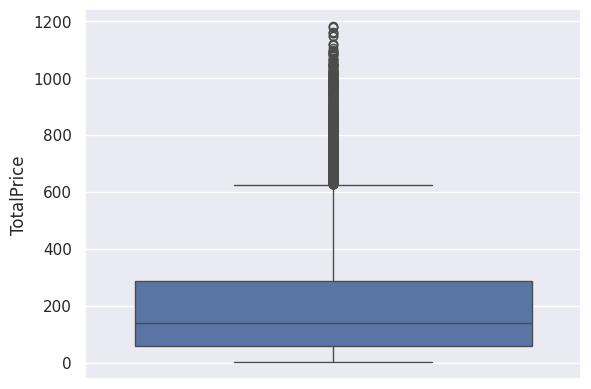

In [24]:
sns.boxplot(data=df["TotalPrice"])

## Making rfm dataset

In [25]:
# I'll keep most recent transaction in the dataset as the reference
reference_date = df['TransactionDate'].max()

# Calculating Recency
recency_df = df.groupby('CustomerID')['TransactionDate'].max().reset_index()
recency_df['Recency'] = (reference_date - recency_df['TransactionDate']).dt.days

# Calculating Frequency
frequency_df = df.groupby('CustomerID').size().reset_index(name='Frequency')

# Calculating Monetary Value
monetary_df = df.groupby('CustomerID')['TotalPrice'].sum().reset_index(name='MonetaryValue')

# Merging the RFM components into a single DataFrame
rfm_df = recency_df[['CustomerID', 'Recency']].merge(frequency_df, on='CustomerID')
rfm_df = rfm_df.merge(monetary_df, on='CustomerID')

print("RFM DataFrame:")
display(rfm_df.head())

RFM DataFrame:


,CustomerID,Recency,Frequency,MonetaryValue
0,CUST1000,8,41,6855.79
1,CUST1001,48,10,2856.43
2,CUST1002,6,25,2175.73
3,CUST1003,21,33,1085.57
4,CUST1004,133,27,6887.81


## K mean clustering

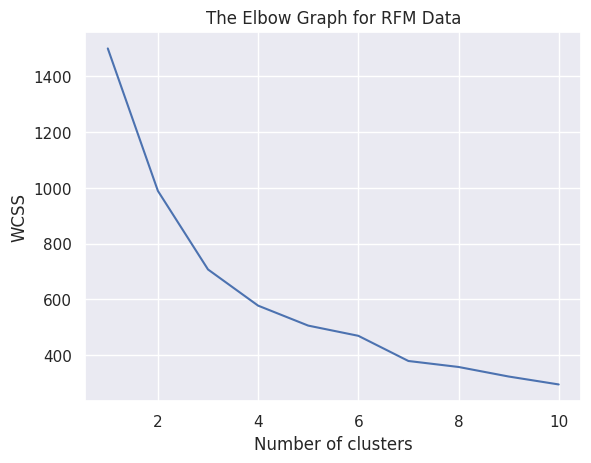

In [26]:
from sklearn.preprocessing import StandardScaler

X = rfm_df[['Recency', 'Frequency', 'MonetaryValue']]

# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determining the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plotting the elbow graph
sns.set()
plt.plot(range(1, 11), wcss)
plt.title("The Elbow Graph for RFM Data")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()



In [27]:
optimal_clusters = 2

# Applying K-Means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(X_scaled)

print("\nRFM DataFrame with Clusters:")
display(rfm_df.head())

print("\nCluster Analysis (Mean RFM values per cluster):")
display(rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'MonetaryValue']].mean())


RFM DataFrame with Clusters:


,CustomerID,Recency,Frequency,MonetaryValue,Cluster
0,CUST1000,8,41,6855.79,1
1,CUST1001,48,10,2856.43,0
2,CUST1002,6,25,2175.73,0
3,CUST1003,21,33,1085.57,0
4,CUST1004,133,27,6887.81,0



Cluster Analysis (Mean RFM values per cluster):


,Recency,Frequency,MonetaryValue
Cluster,,,
0,82.206667,24.876667,3598.060767
1,52.465000,38.400000,10300.817850


In [28]:
print(rfm_df[['Recency', 'Frequency', 'MonetaryValue']].dtypes)

Recency            int64
Frequency          int64
MonetaryValue    float64
dtype: object


In [29]:
Y = rfm_df[['Recency', 'Frequency', 'MonetaryValue']]
X = rfm_df[['Cluster']]

## Visualization of clusters

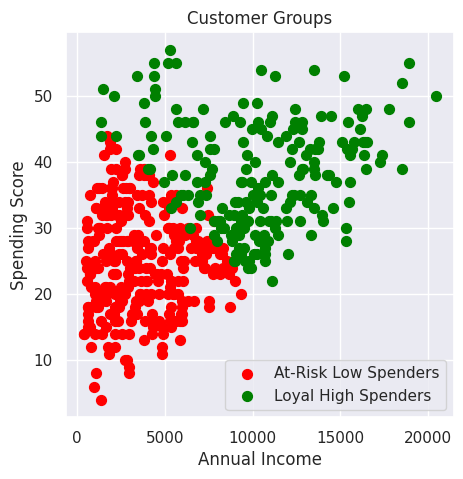

In [30]:
plt.figure(figsize=(5,5))
plt.scatter(rfm_df.loc[rfm_df['Cluster'] == 0, 'MonetaryValue'], rfm_df.loc[rfm_df['Cluster'] == 0, 'Frequency'], s=50, c='red', label='At-Risk Low Spenders')
plt.scatter(rfm_df.loc[rfm_df['Cluster'] == 1, 'MonetaryValue'], rfm_df.loc[rfm_df['Cluster'] == 1, 'Frequency'], s=50, c='green', label='Loyal High Spenders')
plt.legend()
plt.title('Customer Groups')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.show()

In [31]:
customer_segments = rfm_df[['CustomerID', 'Cluster']]

# Labeling the clusters
Cluster = {0: 'At-Risk Customer', 1: 'Loyal Customer'}

customer_segments['Cluster'] = customer_segments['Cluster'].map(Cluster)

# Saving the DataFrame to a CSV file
customer_segments.to_csv('customer_segments.csv', index=False)

<ipython-input-31-9a326821abee>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_segments['Cluster'] = customer_segments['Cluster'].map(Cluster)


### Checking new generated data

In [35]:
segmented_df = pd.read_csv("customer_segments.csv")

In [36]:
segmented_df.head(10)

,CustomerID,Cluster
0,CUST1000,Loyal Customer
1,CUST1001,At-Risk Customer
2,CUST1002,At-Risk Customer
3,CUST1003,At-Risk Customer
4,CUST1004,At-Risk Customer
5,CUST1005,At-Risk Customer
6,CUST1006,Loyal Customer
7,CUST1007,At-Risk Customer
8,CUST1008,At-Risk Customer
9,CUST1009,Loyal Customer
